## Convert NLCD Raster Images to Vector Polygons  
A workbook to process National Land Cover Database raster data into vector poygons and create an interactive map.

#### Data Source
The data used in this notebook were obtained from the Multi-Resolution Land Characteristics (MRLC) Consortium website. 

#### Import needed Python Libraries

In [1]:
import geopandas as gpd
import matplotlib.pyplot as plt
%matplotlib inline
import json
from ipyleaflet import (
    Map,
    GeoJSON
)
import os.path

#### Import the colors and definitions

In [2]:
import color_keys
colors_dict = color_keys.colors_dict
color_definition = color_keys.color_definition

#### Create temp-data folder

In [3]:
temp_path = 'temp-data'
if not os.path.exists(temp_path):
  os.makedirs(temp_path)

#### Convert the Raster data (tiff) to Vector (gpkg)

In [4]:
!gdal_polygonize.py /vsizip/sources/NLCD_Punta_Gorda_area.zip/NLCD_2019_Land_Cover_L48_20210604_6Ryotb4ak7ugzjap47E4.tiff -b 1 -f "GPKG" temp-data/NLCD_vector2.gpkg NLCD_vector DN

Creating output temp-data/NLCD_vector2.gpkg of format GPKG.
0...10...20...30...40...50...60...70...80...90...100 - done.


#### Convert the Conus Albers format to WGS84 and save as GeoJson data

In [5]:
!ogr2ogr -where "\"DN\" > 0" -s_srs EPSG:5070 -t_srs EPSG:4326 -f GEOJSON temp-data/NLCD_Punta_Gorda_area_WGS84.geojson temp-data/NLCD_vector2.gpkg

ERROR 1: Point outside of projection domain
ERROR 1: Point outside of projection domain


#### Use mapshaper to simplify the geojson output data

In [6]:
!mapshaper temp-data/NLCD_Punta_Gorda_area_WGS84.geojson -simplify dp 20% -o format=geojson temp-data/NLCD_Punta_Gorda_area_WGS84_simplified.geojson

[simplify] Repaired 306 intersections; 46,843 intersections could not be repaired
[o] Wrote temp-data/NLCD_Punta_Gorda_area_WGS84_simplified.geojson


#### Load data to GeoPandas to verify projection

In [7]:
df = gpd.read_file('temp-data/NLCD_Punta_Gorda_area_WGS84_simplified.geojson')
print ('columns', df.columns)
df.crs

columns Index(['DN', 'geometry'], dtype='object')


<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

#### Using MatplotLib plot the GeoPandas data

<AxesSubplot:>

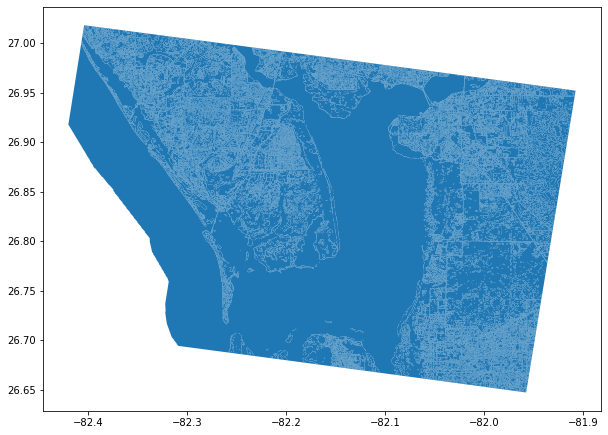

In [8]:
df.plot(aspect=1,figsize=(10,10))

#### Load GeoJson data and return the count of features within the file

In [9]:
with open("temp-data/NLCD_Punta_Gorda_area_WGS84.geojson") as f:
    data = json.load(f)

n_features = len(data["features"])
print('number of features in the geojson: ',n_features)

number of features in the geojson:  84816


#### Review the GeoJson data prior to adding more properties

In [10]:
data["features"][1:3]

[{'type': 'Feature',
  'properties': {'DN': 22},
  'geometry': {'type': 'Polygon',
   'coordinates': [[[-82.40347035421655, 27.01800522064114],
     [-82.40351319211646, 27.017735582415604],
     [-82.40291844392762, 27.01765789511024],
     [-82.40287560420809, 27.017927533152722],
     [-82.40347035421655, 27.01800522064114]]]}},
 {'type': 'Feature',
  'properties': {'DN': 21},
  'geometry': {'type': 'Polygon',
   'coordinates': [[[-82.40287560420809, 27.017927533152722],
     [-82.40291844392762, 27.01765789511024],
     [-82.40262107023472, 27.01761905018552],
     [-82.4025782296054, 27.017888688136473],
     [-82.40287560420809, 27.017927533152722]]]}}]

#### Add properties to the geojson data to report color, styles, and description for each polygon

In [11]:
for i in range(0, n_features):
    feature_ID = data["features"][i]['properties']['DN']

    for color_code in colors_dict:
        for key in color_code:
            if (key == feature_ID):
                data["features"][i]["properties"]["color"] = color_code[feature_ID]
                data["features"][i]["properties"]["style"] = {
                    "color": color_code[feature_ID],
                    "weight": 1,
                    "fillColor": color_code[feature_ID],
                    "fillOpacity": 0.55
                }
    for color_def in color_definition:           
        for key in color_def:
            if (key == feature_ID):
                data["features"][i]["properties"]["description"] = color_def[feature_ID]
data["features"][1:3]

[{'type': 'Feature',
  'properties': {'DN': 22,
   'color': '#E29E8C',
   'style': {'color': '#E29E8C',
    'weight': 1,
    'fillColor': '#E29E8C',
    'fillOpacity': 0.55},
   'description': 'Developed Low Intensity'},
  'geometry': {'type': 'Polygon',
   'coordinates': [[[-82.40347035421655, 27.01800522064114],
     [-82.40351319211646, 27.017735582415604],
     [-82.40291844392762, 27.01765789511024],
     [-82.40287560420809, 27.017927533152722],
     [-82.40347035421655, 27.01800522064114]]]}},
 {'type': 'Feature',
  'properties': {'DN': 21,
   'color': '#E8D1D1',
   'style': {'color': '#E8D1D1',
    'weight': 1,
    'fillColor': '#E8D1D1',
    'fillOpacity': 0.55},
   'description': 'Developed Open Space'},
  'geometry': {'type': 'Polygon',
   'coordinates': [[[-82.40287560420809, 27.017927533152722],
     [-82.40291844392762, 27.01765789511024],
     [-82.40262107023472, 27.01761905018552],
     [-82.4025782296054, 27.017888688136473],
     [-82.40287560420809, 27.0179275331527

### Create a map centered on the Punta Gorda,FL area

In [12]:
center = [26.919166, -82.164682] 
zoom = 12

m = Map(center=center, zoom=zoom)

#### Add the geojson data to the map

In [13]:
g = GeoJSON(data=data)

In [14]:
m.add(g)

Map(center=[26.919166, -82.164682], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title'…

#### Add logic to the map for a popup when hovering over a polygon

In [15]:
from ipywidgets import Text, HTML
from ipyleaflet import WidgetControl, GeoJSON

html1 = HTML(
    """
    Hover over color for definition
"""
)
html1.layout.margin = "0px 10px 10px 10px"
control1 = WidgetControl(widget=html1, position="bottomright")
m.add(control1)


def update_html(feature, **kwargs):
    html1.value = """
        <h4><b>{}- {}</b></h4>
    """.format(
        feature["properties"]["DN"], feature["properties"]["description"]
    )


g.on_hover(update_html)

#### Prepare data for output to file

In [16]:
# Serializing json
json_object = json.dumps(data, indent=4)

#### Write styled geojson to file

In [17]:
# Writing to sample.json
with open("temp-data/NLCD_Punta_Gorda_area_WGS84_styled.geojson", "w") as outfile:
    outfile.write(json_object)

#### Use mapshaper to simplify the geojson output data

In [18]:
!mapshaper temp-data/NLCD_Punta_Gorda_area_WGS84_styled.geojson -simplify dp 20% -o format=geojson sources/NLCD_Punta_Gorda_area_WGS84.geojson

[simplify] Repaired 306 intersections; 46,843 intersections could not be repaired
[o] Wrote sources/NLCD_Punta_Gorda_area_WGS84.geojson


#### Delete temp-data folder

In [19]:
if os.path.exists(temp_path):
    !rm -rf temp-data

#### Other data downloads in the sources folder  
These files can be plugged into the cells above to analyze land cover in other areas

| Download Name  |      Tiff File Name      |  
|----------|:-------------:  
NLCD_Jacksonville_area.zip | NLCD_2019_Land_Cover_L48_20210604_v1AdZOChAH6SMKC8JfEn.tiff
NLCD_Sanibel_area.zip | NLCD_2019_Land_Cover_L48_20210604_98Ejuh2wAV8IMNpUssoI.tiff
NLCD_Punta_Gorda_area.zip | NLCD_2019_Land_Cover_L48_20210604_6Ryotb4ak7ugzjap47E4.tiff

#### [National Land Cover Database Class Legend and Descriptions](https://www.mrlc.gov/data/legends/national-land-cover-database-class-legend-and-description)

#### [An interactive web map of the final output](https://markcruse.github.io/raster-images-to-vector-polygon/)